In [1]:
#Get a few dependencies
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics .tsaplots import plot_acf, plot_pacf
from sklearn import metrics                     #Some specific things from sklearn
from sklearn import linear_model
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# -- Check out the data -- 

#Load in the datasets
clustering_df = pd.read_csv('data/dataClustering.csv', names=["feature_" + str(i+1) for i in range(8)])
cleanSine_df = pd.read_csv('data/cleanSine.csv', names=["clean"])
noisySine_df = pd.read_csv('data/noisySine.csv', names=["noisy"])
xvalsSine_df = pd.read_csv('data/xvalsSine.csv', names=["xvals"])

In [3]:
#
# --- Unsupervised + supervised learning --- 
#

# i) Perform any clustering of your choice to determine the optimal # of clusters in the data
# ii) Using the result of i) assign clusters labels to each sample, so each sample's label is the
# cluster to which it belongs. Using these labels as the exact labels, you now have a labeled dataset.
# Build a classification model that classifies a sample with its corresponding label. Use multinomial 
# regression as a benchmark model, and any ML model (trees, forests, SVM, NN etc.) as a comparison model.
# Comment on which does better and why.

Clustering_df info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  2500 non-null   float64
 1   feature_2  2500 non-null   float64
 2   feature_3  2500 non-null   float64
 3   feature_4  2500 non-null   float64
 4   feature_5  2500 non-null   float64
 5   feature_6  2500 non-null   float64
 6   feature_7  2500 non-null   float64
 7   feature_8  2500 non-null   float64
dtypes: float64(8)
memory usage: 156.4 KB
None 

         feature_1    feature_2    feature_3    feature_4    feature_5  \
count  2500.000000  2500.000000  2500.000000  2500.000000  2500.000000   
mean      1.315873     0.232581     0.896288     0.087122     1.090401   
std       3.954106     5.228858     5.077481     4.727901     6.889142   
min      -8.698889   -11.193478    -9.457285    -9.339854   -15.230702   
25%      -1.775723    -4.483005    -3.245982    -3.951

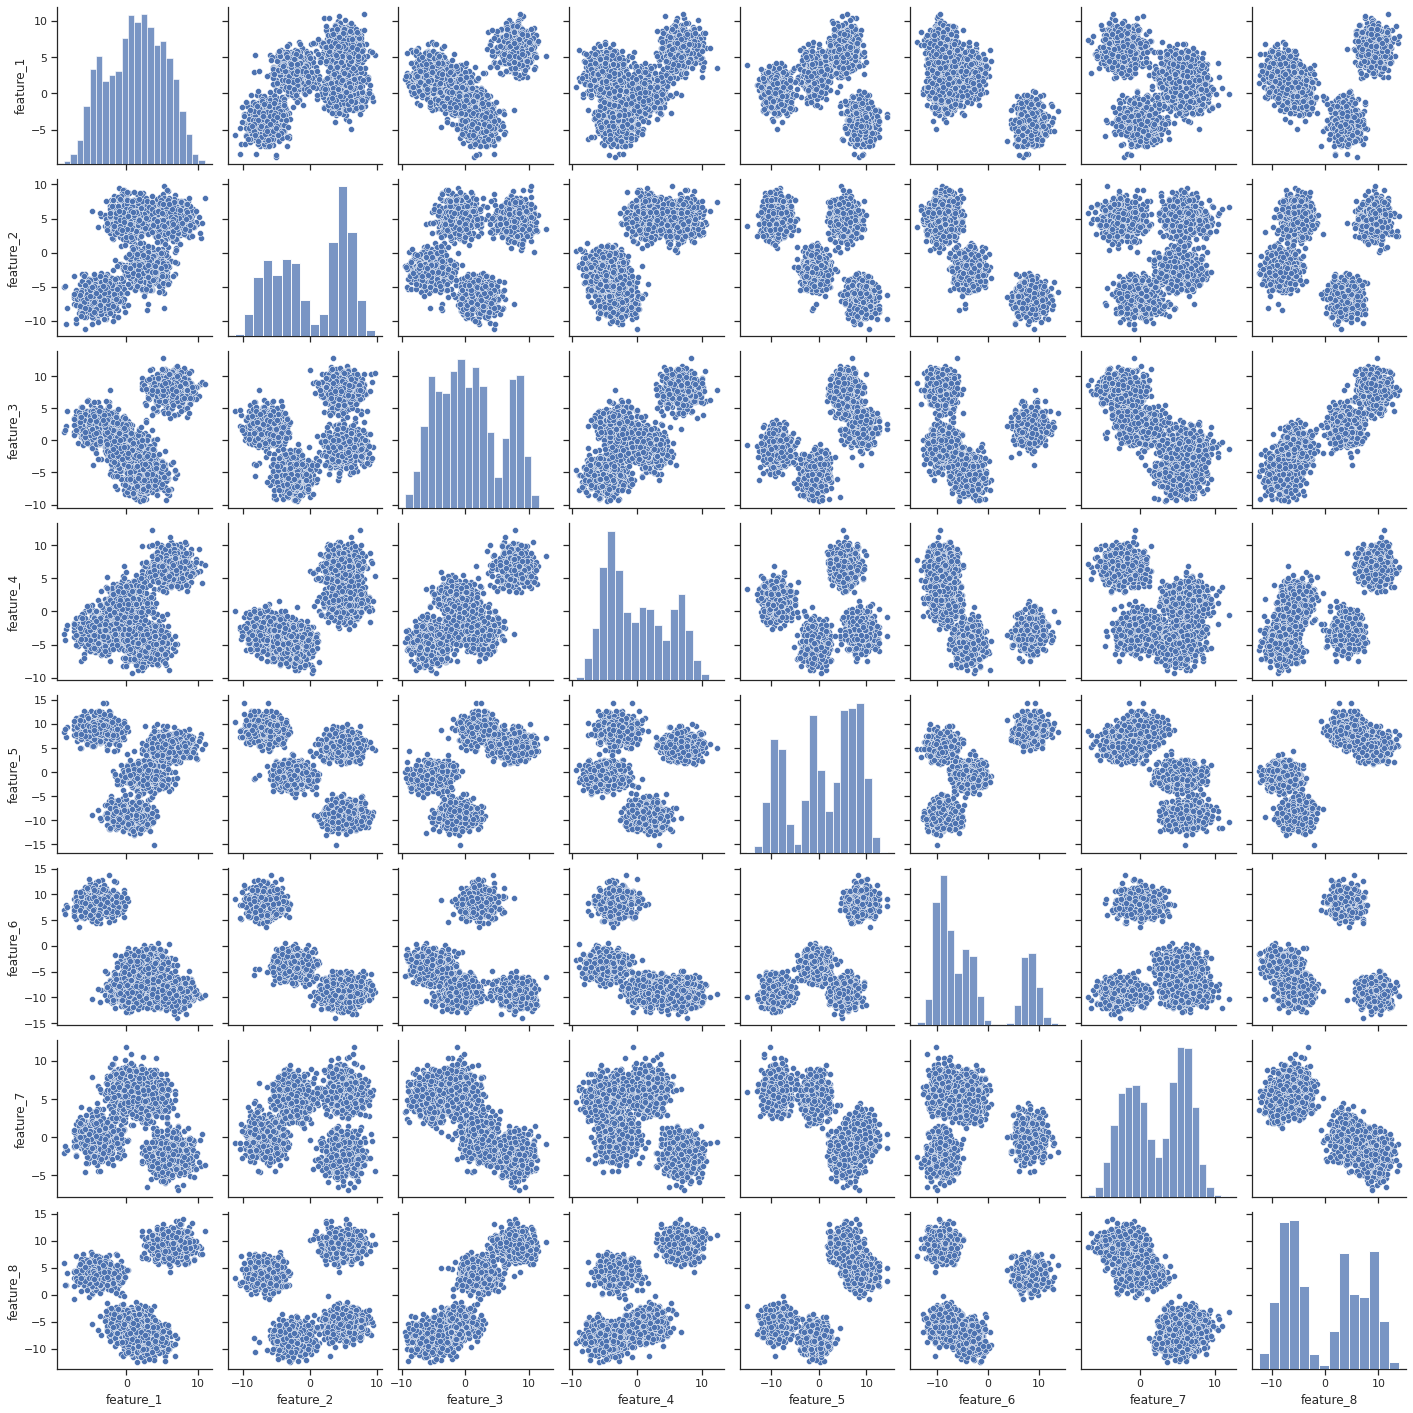

In [4]:
#take a peek at clustering df
print("Clustering_df info:\n")
print(clustering_df.info(), "\n")
print(clustering_df.describe(), "\n\n")
#print(clustering_df.nunique())
print("The Data: ")
print(clustering_df.head(16))

sns.set_theme(style="ticks")
sns.pairplot(clustering_df)

In [5]:
# Note - 
# For clustering I would usualy normalize the data so distance-based algos can work off variable relationships rather than scale,
# but I'm going to try this exercise without normalizaing b/c the scale of the data provided is pretty balanced

<function matplotlib.pyplot.show(close=None, block=None)>

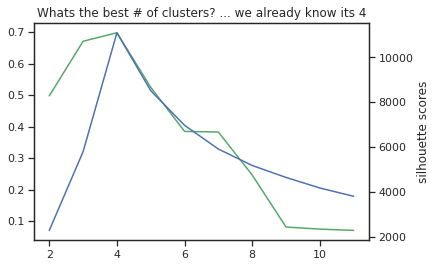

In [6]:
#Tune # of clusters -- 

#Check a range of cluster numbers for best fit
silho_score, cali_score = [], []
for clusters_nums in list(range(2,12)):
    
    #the model
    mini_means = MiniBatchKMeans(n_clusters=clusters_nums,
                                 random_state=14,
                                 batch_size=20)
    
    #Fit on the data and score
    mini_means.fit_predict(clustering_df)
    clustering_df['clusters'] = mini_means.labels_
    silho_score.append(metrics.silhouette_score(clustering_df.loc[:,"feature_1":"feature_8"], clustering_df['clusters'], metric='euclidean'))
    cali_score.append(metrics.calinski_harabasz_score(clustering_df.loc[:,"feature_1":"feature_8"], clustering_df['clusters']))
    

#Plot the results
sns.lineplot(x=list(range(2,12)), y=silho_score, color="g")
ax2 = plt.twinx()
sns.lineplot(x=list(range(2,12)), y=cali_score, color="b", ax=ax2)
ax2.set(xlabel='# of clusters', ylabel='calinski scores (right)')
plt.xlabel('# of clusters')
plt.ylabel("silhouette scores")
plt.title("Whats the best # of clusters? ... we already know its 4") 
plt.show


What the clusters look like:



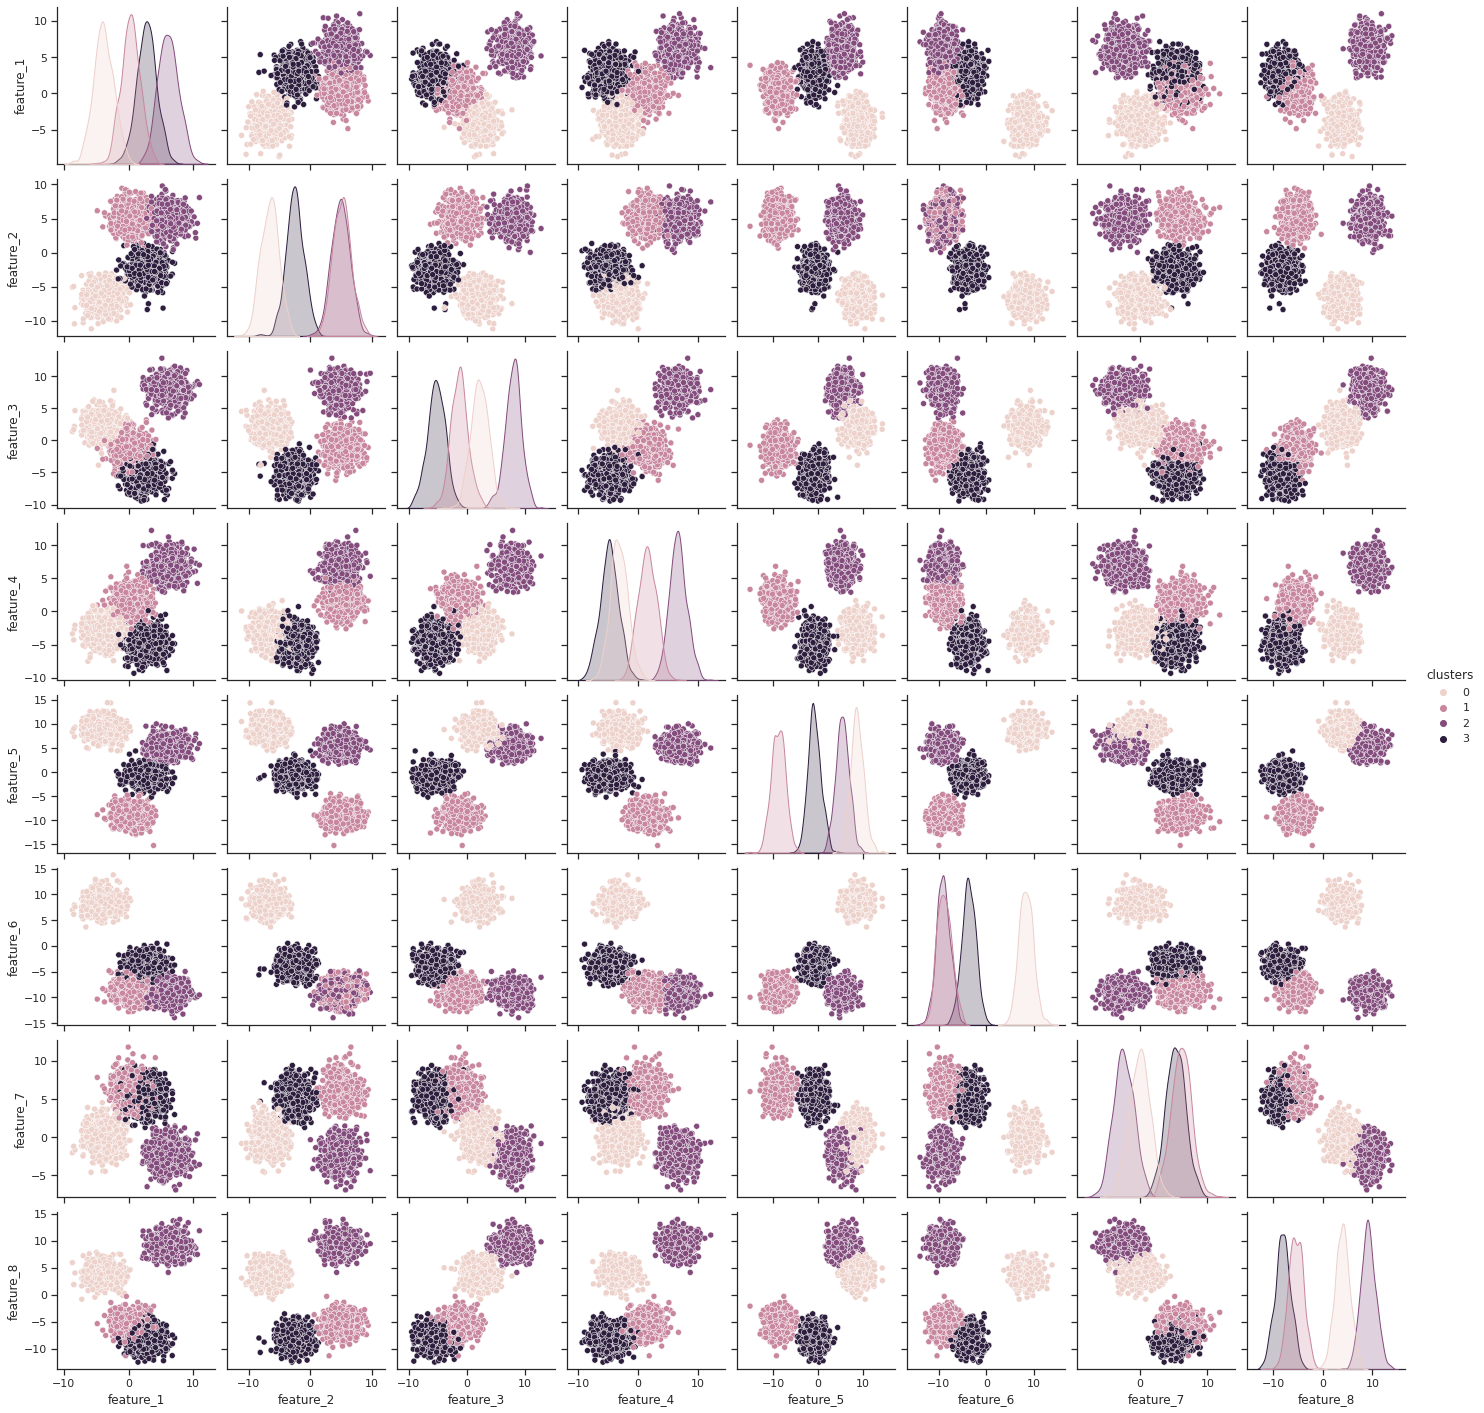

In [7]:
#Try some clustering -- Basically you can eyeball it and see 4 clusters. I'll do elbow method with Silhouette / Davies-Bouldin

#Minibatch KMeans
mini_means = MiniBatchKMeans(n_clusters=4,
                             random_state=14,
                             batch_size=20)
#Fit / predict on the data
mini_means.fit_predict(clustering_df)
clustering_df['clusters'] = mini_means.labels_

#Check the visuals
print("\nWhat the clusters look like:\n")
sns.set_theme(style="ticks")
sns.pairplot(clustering_df, hue='clusters')

# mini_means.labels_
# mini_means.cluster_centers_

In [8]:

# --- Regression (Q1 part ii) ---

#Classification Battle between Logistic Regression and RandomForest
#Basic Regression Model, Basic Random Forest Model
basic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
forest_model = RandomForestClassifier(n_estimators=10)

#Cross Validation to score them
cross_vali = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=14)
basic_score = cross_val_score(basic_model,
                              clustering_df.loc[:,"feature_1":"feature_8"],
                              clustering_df["clusters"],
                              scoring='accuracy',
                              cv=cross_vali,
                              n_jobs=-1)
forest_score = cross_val_score(forest_model,
                              clustering_df.loc[:,"feature_1":"feature_8"],
                              clustering_df["clusters"],
                              scoring='accuracy',
                              cv=cross_vali,
                              n_jobs=-1)

#Model Accuracy
print('Regression Mean Accuracy: %.3f (%.3f)' % (mean(basic_score), std(basic_score)))
print('Forest Mean Accuracy: %.3f (%.3f)' % (mean(forest_score ), std(forest_score)))
print("\nBoth models are perfect? ... the dataset is too beautiful at four clusters. \nWhen you get over 4 clusters the models start to show falliability")

Regression Mean Accuracy: 1.000 (0.000)
Forest Mean Accuracy: 1.000 (0.001)

Both models are perfect? ... the dataset is too beautiful at four clusters. 
When you get over 4 clusters the models start to show falliability


In [9]:
# 2) Prediction + filtering
# --------------------------

# Attached are 3 files: xvalsSine.csv, cleanSine.csv and noisySine.csv. xvalsSine.csv contains
# 1000 x-values in the interval -pi/2 to pi/2. cleanSine.csv is a pure sine(x) function for the
# x values mentioned earlier. noisySine.csv contains sine(x) corrupted by noise. 
# i) Using xvalsSine.csv and cleanSine.csv as a labeled dataset (x,sine(x)) being (value,label) with a
# random train/test split of 0.7/0.3, build an OLS regression model (you may want to use polynomial
# basis of a sufficiently large order). 
# (bonus) If you used the normal equations to solve the OLS problem, can you redo it with stochastic
# gradient descent?
# ii) Now, assume you are given the noisySine.csv as a time series with the values of 
# xvalsSine.csv being the time variable. Filter the noisySine.csv data with any filter of your choice
# and compare against cleanSine.csv to report the error.
# (bonus) Can you code a Kalman filter to predict out 10 samples from the noisySine.csv data?

Noisy sine is blue, clean sine is orange


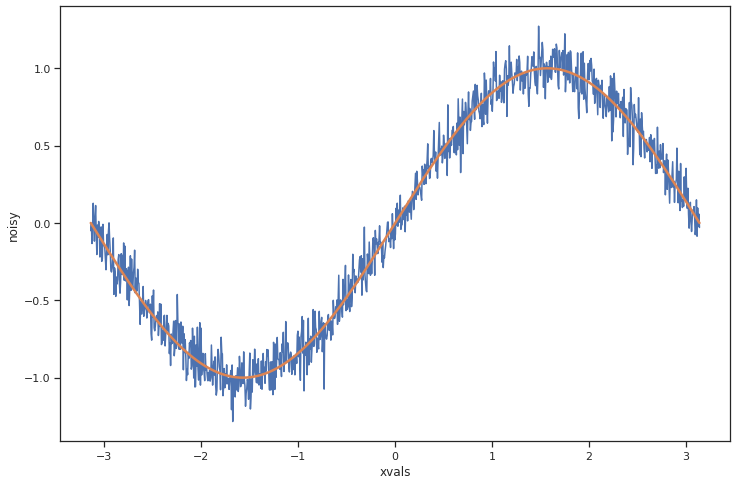

In [10]:
#This is what noisy looks like
fig = plt.figure(figsize=(12, 8))
sns.lineplot(x=xvalsSine_df['xvals'], y=noisySine_df.noisy)
sns.lineplot(x=xvalsSine_df['xvals'], y=cleanSine_df.clean, linewidth=2.5)

print("Noisy sine is blue, clean sine is orange")

In [11]:
#Polynmial basis of sufficiently large order?
x_poly = pd.DataFrame([[x**i for x in list(xvalsSine_df['xvals'])] for i in range(1,6)]).T
x_poly.columns = ["xval_"+ str(i) for i in range(1,6)]
x_poly['ysine'] = cleanSine_df
x_poly

,xval_1,xval_2,xval_3,xval_4,xval_5,ysine
0,-3.141593,9.869604,-31.006277,97.409091,-306.019685,-1.224647e-16
1,-3.135303,9.830126,-30.820425,96.631378,-302.968665,-6.289433e-03
2,-3.129014,9.790727,-30.635318,95.858330,-299.942030,-1.257862e-02
3,-3.122724,9.751407,-30.450954,95.089931,-296.939631,-1.886730e-02
4,-3.116435,9.712166,-30.267330,94.326160,-293.961324,-2.515525e-02
...,...,...,...,...,...,...
995,3.116435,9.712166,30.267330,94.326160,293.961324,2.515525e-02
996,3.122724,9.751407,30.450954,95.089931,296.939631,1.886730e-02
997,3.129014,9.790727,30.635318,95.858330,299.942030,1.257862e-02
998,3.135303,9.830126,30.820425,96.631378,302.968665,6.289433e-03


In [12]:
#Sample into train(70%) and test(30%)
sine_train = x_poly.sample(frac = .7)
sine_test = x_poly[~x_poly.index.isin(sine_train.index)]

#Check to make sure there is no overlap ... this should be blank
pd.merge(sine_train, sine_test, on=list(x_poly.columns), how='inner')

,xval_1,xval_2,xval_3,xval_4,xval_5,ysine


In [13]:
#Make the linear model 
sine_model = linear_model.LinearRegression()
sine_model.fit(sine_train.loc[:, 'xval_1':'xval_5'], sine_train['ysine'])

#Show Coefficients
print("Model Coefficients:")
print(pd.Series(sine_model.coef_, index=list(x_poly.columns[:-1])))

#Lets see how it does
from sklearn.metrics import mean_squared_error
preds = list(sine_model.predict(sine_test.loc[:, 'xval_1':'xval_5']))
trues = list(sine_test['ysine'])
print(f'\nMSE for this model is {mean_squared_error(preds, trues)}')


Model Coefficients:
xval_1    0.987877
xval_2    0.000241
xval_3   -0.155237
xval_4   -0.000027
xval_5    0.005639
dtype: float64

MSE for this model is 2.0178370906225752e-05


Noisy sine is blue, filtered sine is orange


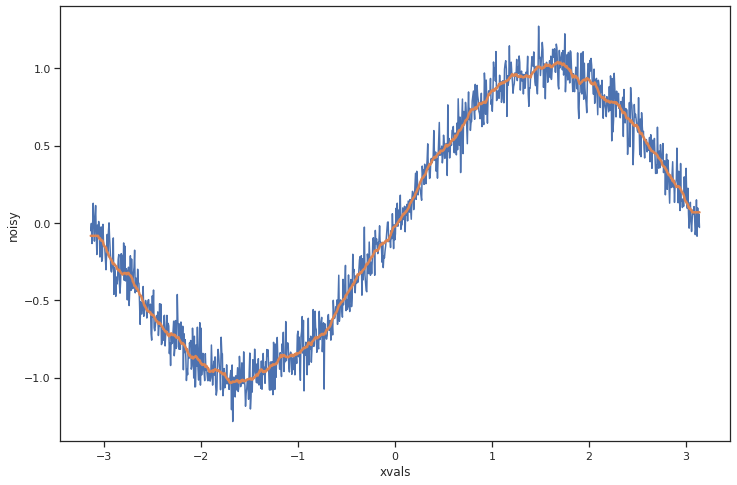

In [14]:
#Try a KNN Regressor filter 
knn_filter = KNeighborsRegressor(n_neighbors=25, weights='uniform')
knn_filter.fit(noisySine_df.index.values[:, np.newaxis], noisySine_df.noisy)
y_filter = knn_filter.predict(noisySine_df.index.values[:, np.newaxis])

#Plot
fig = plt.figure(figsize=(12, 8))
sns.lineplot(x=xvalsSine_df['xvals'], y=noisySine_df.noisy)
sns.lineplot(x=xvalsSine_df['xvals'], y=y_filter, linewidth=2.5)
print("Noisy sine is blue, filtered sine is orange")



#Code for Hodrick-Prescott Filter 

# import statsmodels.api as sm
# sine_cycle, sine_trend = sm.tsa.filters.hpfilter(noisySine_df)
# trend_df = noisySine_df[["noisy"]].copy()
# trend_df["cycle"] = sine_cycle
# trend_df["trend"] = sine_trend

# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_subplot(111)
# trend_df[["noisy", "trend"]].plot(ax=ax, fontsize=16)
# legend = ax.get_legend()
# legend.prop.set_size(20)
# print('Hodrick-Prescott Filter (in orange)')

These are the digits:

3.1415826535897934884626433520295028937284193939649495759086359919592690551729875945272168247348045291378616410833374403367230534872598909920887472292990473998461346290444135431394162868269590211668898895218720865431064231740882080732735281796531548671148507750056306526893550179959350432779139073418207291252220656182374140943434491185727890888789147612567331641573679243672019633602713333718307777572670306505683583614306992747139137486775962648835950333385517141606254664391966387103072182413609982


Text(0.5, 1.0, 'These are our pi digits')

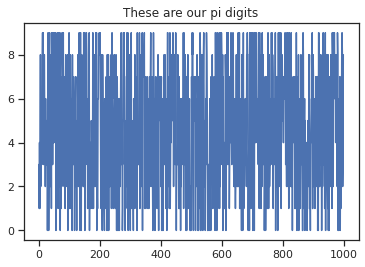

In [15]:
# 3) Time series with pi
# -----------------------
# Attached is a function genPiAppxDigits(numdigits,appxAcc) which returns an approximate value of pi
# to numdigits digits of accuracy. appxAcc is an integer that controls the approximation accuracy, with
# a larger number for appxAcc leading to a better approximation.
# i) Fix numdigits and appxAcc to be sufficiently large, say 1000 and 100000 respectively.
# Treat each of the 1000 resulting digits of pi as the value of a time series. Thus x[n]=nth digit
# of pi for n=1,1000. Build a simple time series forecasting model (any model of your choice)
# that predicts the next 50 digits of pi. Report your accuracy. Using your results, can
# you conclude that pi is irrational? If so, how?
# (bonus) Now let's vary appxAcc to be 1000,5000,10000,50000,100000 with fixed numdigits=1000. You thus
# have 5 time series, each corresponding to a value of appxAcc. Can you find the pairwise correlation
# between each of the time series?

#Given function
def genPiAppxDigits(numdigits,appxAcc):
	import numpy as np
	from decimal import getcontext, Decimal
	getcontext().prec = numdigits
	mypi = (Decimal(4) * sum(-Decimal(k%4 - 2) / k for k in range(1, 2*appxAcc+1, 2)))
	return mypi

print("These are the digits:\n")
print(genPiAppxDigits(500, 100000))

digits = [int(x) for x in str(genPiAppxDigits(1000, 100000)) if x.isnumeric()]
sns.lineplot(x=list(range(len(digits))), y=digits).set_title("These are our pi digits")


Doesn't look like we need to difference the series & dont see autocorrelation



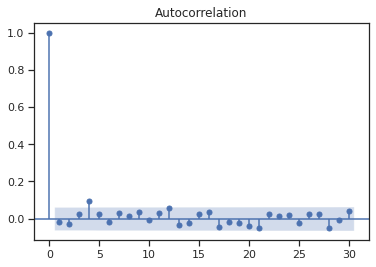

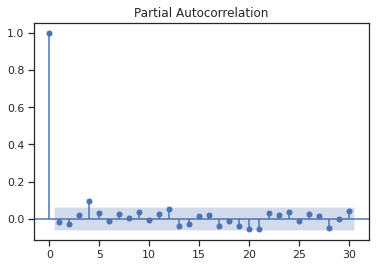

In [16]:
#It looks stationary but lets just check the acf
plot_acf(pd.DataFrame(digits))
plot_pacf(pd.DataFrame(digits))
print("\nDoesn't look like we need to difference the series & dont see autocorrelation\n")


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -2469.506
Date:                Sat, 19 Mar 2022   AIC                           4945.011
Time:                        09:38:04   BIC                           4959.735
Sample:                             0   HQIC                          4950.607
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6470      0.089     52.348      0.000       4.473       4.821
ma.L1         -0.0195      0.032     -0.618      0.537      -0.082       0.042
sigma2         8.1754      0.587     13.925      0.0

<AxesSubplot:ylabel='Density'>

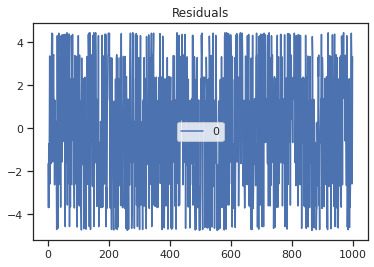

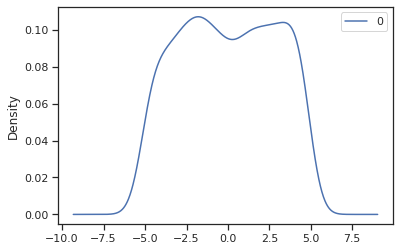

In [17]:
# ARiMA example
# So lets just try a Moving Average Model
model = ARIMA(digits, order=(0, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

#Residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot().set_title("Residuals")
residuals.plot(kind='kde')

Here are our predictions: 
 [4.5821032  4.64697499 4.64697499 4.64697499 4.64697499 4.64697499
 4.64697499 4.64697499 4.64697499 4.64697499 4.64697499 4.64697499
 4.64697499 4.64697499 4.64697499 4.64697499 4.64697499 4.64697499
 4.64697499 4.64697499 4.64697499 4.64697499 4.64697499 4.64697499
 4.64697499 4.64697499 4.64697499 4.64697499 4.64697499 4.64697499
 4.64697499 4.64697499 4.64697499 4.64697499 4.64697499 4.64697499
 4.64697499 4.64697499 4.64697499 4.64697499 4.64697499 4.64697499
 4.64697499 4.64697499 4.64697499 4.64697499 4.64697499 4.64697499
 4.64697499 4.64697499]

Its basically predicting the average of 0~9

RMSE for this model is 2.9483805305558968, and stdev for the pi digits series is 2.859788628552817


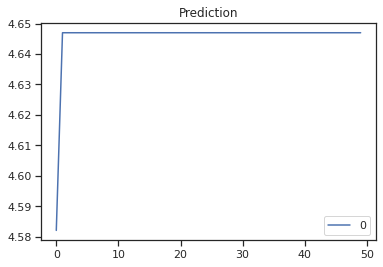

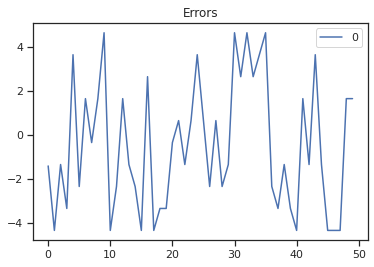

In [18]:
# Make a prediction for the next pu digit
yhat_1 = model_fit.predict(len(digits), len(digits))
yhat_50 = model_fit.predict(start=1000, end=1049)
print("Here are our predictions: \n", yhat_50)

pd.DataFrame(yhat_50).plot().set_title("Prediction")
print("\nIts basically predicting the average of 0~9")

#Now lets see if there is any trend/signal in our errors 
y_true = [int(x) for x in str(genPiAppxDigits(1050, 100000)) if x.isnumeric()][-50:]
y_errors = pd.DataFrame(yhat_50 - y_true).plot().set_title("Errors")
print(f'\nRMSE for this model is {mean_squared_error(yhat_50, y_true)**(1/2)}, and stdev for the pi digits series is {np.std(digits)}')


See how fast these pi estimators diverge...



,acc_1000,acc_5000,acc_10000,acc_50000,acc_100000
0,3,3,3,3,3
1,1,1,1,1,1
2,4,4,4,4,4
3,0,1,1,1,1
4,5,3,4,5,5
5,9,9,9,7,8
6,2,2,2,2,2
7,6,6,6,6,6
8,5,5,5,5,5
9,3,3,3,3,3


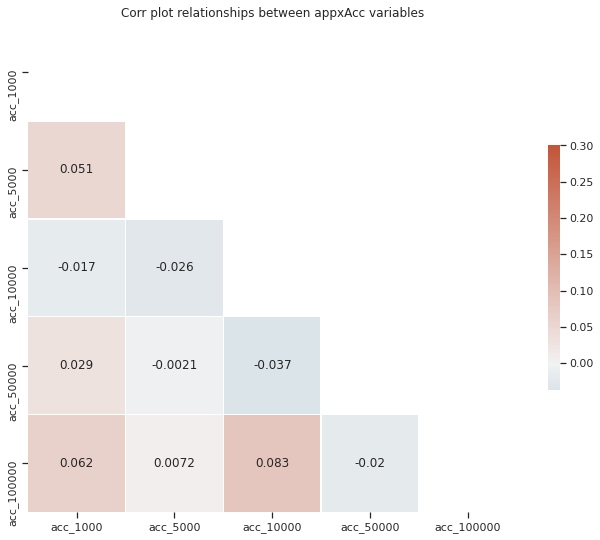

In [19]:
#Lets try taking a look at the cross-correlations (bonus part)
appxAcc_df = pd.DataFrame([[int(x) for x in str(genPiAppxDigits(1000, acc)) if x.isnumeric()] for acc in [1000,5000,10000,50000,100000]]).T
appxAcc_df.columns = ["acc_"+ str(i) for i in [1000,5000,10000,50000,100000]]


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(appxAcc_df.corr(), dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(appxAcc_df.corr(), mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Corr plot relationships between appxAcc variables")
print("\nSee how fast these pi estimators diverge...\n")

appxAcc_df.head(16)

In [20]:
#It seems like the pi digits are just white noise